<h1>Predicting Pharmaceutical Sales</h1>

# Business Understanding
#### Operating Environment
<p>The client is a retailer operating in the pharmaceuitcal industry with a number of stores across the East Cost of Australia. They have recently found increased demand for Vitamin and health products and are seeking to better understand what drives demans so they can take full advantage of the increased market capacity. </p>

#### Business Goal
<p>As of late, the client has found that they are struggling with stockouts. This occurs when there is no stock left of a particular item which is in demand. This has led to lost revenue and missed opportunities for sales. As a result the client wishes to minimize the occurence of stockouts. A large part of minimizing stockouts is predicting sales accurate so that stock levels can be predictive. The formula for closing inventory is given by: </p>
    <blockquote>Closing Inventory = Opening Inventory - Today's Sales + Returns + Stock Deliveries</blockquote>
    
#### Strategy
<p>For stage one of the project, the team has decided to explore the idea of better predicting sales. Future enhancements could involve predicting product returns and using prescriptive analytics to drive stock purchases/deliveries. </p>

#### Source Data
<p>The dataset has been extract from a Planning Analytics sales cube. The finance and operations team typically use PA to plan for their stock levels and sales forecasts hence this has been chosen as the appropriate repository. </p>
   

In [1]:
import warnings

# Import Data

In [2]:
import pandas as pd

In [3]:
from pandas import DataFrame

### Setup IBM Cloud Client
Replace the IBM API KEY ID with yours obtained from IBM COS. This can be obtained by selecting the Find and Add Data tab in the top right, selecting a data source and choosing add credentials.

In [5]:
import types
from botocore.client import Config
import ibm_boto3

client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='<YOUR IBM COS API KEY>',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

### Datasets Available 
We have a number of datasets to work with in this scenario. A data dictionary is provided below:
1. IBMChem_Products.csv
2. IBMChem_Sales.csv
3. IBMChem_stores.csv
4. Weather.csv

These are currently stores in IBM Cloud Object Storage. They can be retrieved easily using the COS client. To upload the datasets, select 

### Import Sales Data from IBM COS

In [6]:
body = client.get_object(Bucket='<YOUR BUCKET>',Key='IBMChem_Sales.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()

,Time Date,Product,Store,Value
0,1012018,2511675,VIC_CW_ST0098,672.0
1,1012018,2511675,VIC_CW_ST0173,616.0
2,1012018,2511675,VIC_CW_ST0142,504.0
3,1012018,2511675,VIC_CW_ST0193,448.0
4,1012018,2511675,VIC_CW_ST0301,392.0


In [7]:
# Convert numerical product id to categorical variable
df['Product'] = df['Product'].astype(str)

In [8]:
df.dtypes

Time Date      int64
Product       object
Store         object
Value        float64
dtype: object

### Import Product Metadata from IBM COS

In [9]:
body = client.get_object(Bucket='<YOUR BUCKET>',Key='IBMChem_Products.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

products = pd.read_csv(body)
products.head()

,ProductID,Good Weather Impact,Brand Affinity,Product Size,Brand,Category,SubCategory,Description
0,2477202,Negative,10,200,Cenovis,Vitamins,Multi Vitamins,Multivitamin & Minerals 200 Tablets
1,2482445,Positive,10,200,Cenovis,Vitamins,"Bones, Joints and Muscles",Mega Calcium +D 200 Tablets Value Pack
2,2485787,Negative,2,168,Blackmores,Vitamins,"Cold, Flu and Immunity",Bio Zinc 168 Tablets
3,2490626,Negative,9,62,Blackmores,Vitamins,"Cold, Flu and Immunity",Bio C 1000mg 62 Tablets Vitamin C
4,2490701,Positive,9,62,Blackmores,Vitamins,Energy,Executive B Stress Formula 62 Tablets


In [10]:
products['ProductID'] = products['ProductID'].astype(str)

In [11]:
products.dtypes

ProductID              object
Good Weather Impact    object
Brand Affinity          int64
Product Size            int64
Brand                  object
Category               object
SubCategory            object
Description            object
dtype: object

### Import Store Metadata from IBM COS

In [12]:
body = client.get_object(Bucket='<YOUR BUCKET>',Key='IBMChem_stores.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

stores = pd.read_csv(body)

In [13]:
stores.columns = ['Store', 'Store Description', 'Address', 'Suburb', 'State', 'Phone', 'Lat', 'Long', 'RegionAffluence']

In [14]:
stores['State'] = stores['Store'].apply(lambda x: x[:3].strip())

In [15]:
stores.head()

,Store,Store Description,Address,Suburb,State,Phone,Lat,Long,RegionAffluence
0,QLD_CW_ST0005,Chemist Warehouse Adelaide Street Brisbane,SH6 215 Adelaide St,Brisbane,QLD,07 3221 3905,-27.46739,153.02692,1.1
1,QLD_CW_ST0203,Chemist Warehouse Fortitude Valley,Sh 43 to 46 Emporium Centre 1000 Ann St,Fortitude Valley,QLD,07 3252 2645,-27.45350,153.03949,1.4
2,QLD_CW_ST0113,Chemist Warehouse Annerley,493 Ipswich Road,Annerley,QLD,07 3848 1046,-27.51223,153.03114,0.9
3,QLD_CW_ST0098,Chemist Warehouse Indooroopilly,Shop 1 34 Coonan St Indooroopilly Centro,Indooroopilly,QLD,07 3720 0511,-27.49723,152.97599,0.8
4,QLD_CW_ST0132,Chemist Warehouse Mt Gravatt,Shop 10 Mt Gravatt Homemaker Centre 1230 Loga...,Mount Gravatt,QLD,07 3349 3430,-27.53004,153.07291,0.7


### Import Weather Data from IBM COS

In [16]:
body = client.get_object(Bucket='<YOUR BUCKET>',Key='Weather.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

weather = pd.read_csv(body)
weather.head()

,Date,State,Temperature,Precipitation
0,1012018,NSW,23,0.00
1,2012018,NSW,24,3.05
2,3012018,NSW,21,0.51
3,4012018,NSW,21,0.00
4,5012018,NSW,22,0.00


# Data Understanding
<p>The CRISP-DM methodology has been followed to ensure industry agreed best practices are used. Following obtaining an understanding of the busienss the next focus is to obtain an understanding of the data available. This includes obtaining an understanding of data structures, types, data quality and relationships.</p>

## Basic Data Checking

### Check data format
- Data is sales data by product, account, store and day
- Date format is ddmmyyy

In [17]:
# Review data format 
df.head()

,Time Date,Product,Store,Value
0,1012018,2511675,VIC_CW_ST0098,672.0
1,1012018,2511675,VIC_CW_ST0173,616.0
2,1012018,2511675,VIC_CW_ST0142,504.0
3,1012018,2511675,VIC_CW_ST0193,448.0
4,1012018,2511675,VIC_CW_ST0301,392.0


### Review summary statistics
- 18 Stores
- 69 Products within the dataset

In [18]:
df.describe()

,Time Date,Value
count,4.533300e+05,453330.000000
mean,1.578783e+07,357.277461
std,8.796734e+06,258.385466
min,1.012018e+06,6.982500
25%,8.082018e+06,135.107700
50%,1.603202e+07,301.945644
75%,2.310202e+07,536.495400
max,3.112202e+07,1386.000000


In [19]:
df.describe(include=['object'])

,Product,Store
count,453330,453330
unique,69,18
top,2498307,QLD_CW_ST0098
freq,6570,25185


### Review Data Types
- Time Date should be a DateTime Object
- Account should be categorical
- Product should be categorical

In [20]:
df.dtypes

Time Date      int64
Product       object
Store         object
Value        float64
dtype: object

### Check for missing values
- No missing values noted

In [21]:
df.isnull().sum()

Time Date    0
Product      0
Store        0
Value        0
dtype: int64

### Merge Dataframes

In [22]:
abt = pd.merge(df, stores, how='left')
abt = pd.merge(abt, products, left_on='Product', right_on='ProductID', how='left')
abt = pd.merge(abt, weather, left_on=['State', 'Time Date'], right_on=['State','Date'], how='left')
abt.drop('Date',axis = 1, inplace=True)
abt['Time Date'] = abt['Time Date'].apply(lambda x: '0' + str(x) if len(str(x)) < 8 else str(x))
abt['Time Date'] = pd.to_datetime(abt['Time Date'], format='%d%m%Y')

In [23]:
abt.head()

,Time Date,Product,Store,Value,Store Description,Address,Suburb,State,Phone,Lat,...,ProductID,Good Weather Impact,Brand Affinity,Product Size,Brand,Category,SubCategory,Description,Temperature,Precipitation
0,2018-01-01,2511675,VIC_CW_ST0098,672.0,Chemist Warehouse Melbourne,Shop L2 345 Bourke St,Melbourne,VIC,03 9671 3833,-37.81431,...,2511675,Negative,10,60,Cenovis,Vitamins,"Cold, Flu and Immunity",Mega C,20,0.0
1,2018-01-01,2511675,VIC_CW_ST0173,616.0,Chemist Warehouse Hawthorn,745 Glenferrie Road,Hawthorn,VIC,03 9818 3999,-37.81810,...,2511675,Negative,10,60,Cenovis,Vitamins,"Cold, Flu and Immunity",Mega C,20,0.0
2,2018-01-01,2511675,VIC_CW_ST0142,504.0,Chemist Warehouse Northcote,381-385 High St,Northcote,VIC,03 9482 3099,-37.76945,...,2511675,Negative,10,60,Cenovis,Vitamins,"Cold, Flu and Immunity",Mega C,20,0.0
3,2018-01-01,2511675,VIC_CW_ST0193,448.0,Chemist Warehouse Caroline Springs,Shop 2 to 6 Caroline Springs Boulevard,Caroline Springs,VIC,03 9449 5400,-37.73892,...,2511675,Negative,10,60,Cenovis,Vitamins,"Cold, Flu and Immunity",Mega C,20,0.0
4,2018-01-01,2511675,VIC_CW_ST0301,392.0,Chemist Warehouse Dandenong,265 Lonsdale Street,Dandenong,VIC,03 9792 0522,-37.98762,...,2511675,Negative,10,60,Cenovis,Vitamins,"Cold, Flu and Immunity",Mega C,20,0.0


In [24]:
abt.to_csv('IBMChem Analytical Base Table.csv')

In [25]:
client.upload_file('IBMChem Analytical Base Table.csv', '<YOUR BUCKET>', 'IBMChem Analytical Base Table.csv')

# Visualization

In [26]:
from matplotlib import pyplot as plt
import seaborn as sns

## Analysing Sales by Subcategory
- Good weather impact flag highlights that sales are somewhat influenced by the time of the year. 
- Cold and Flu, MultiVitamins and Omega 3 appear to sell better in the winter/colder months.
- Beauty, Joint and Energy supplements to sell better in the hotter/summer months.

These insights appear consistent with the businesses known product sales trends.

### Plot By Subcategory

In [27]:
subcat = abt.groupby(['SubCategory','Time Date']).sum()

In [28]:
subcat.reset_index(inplace=True)

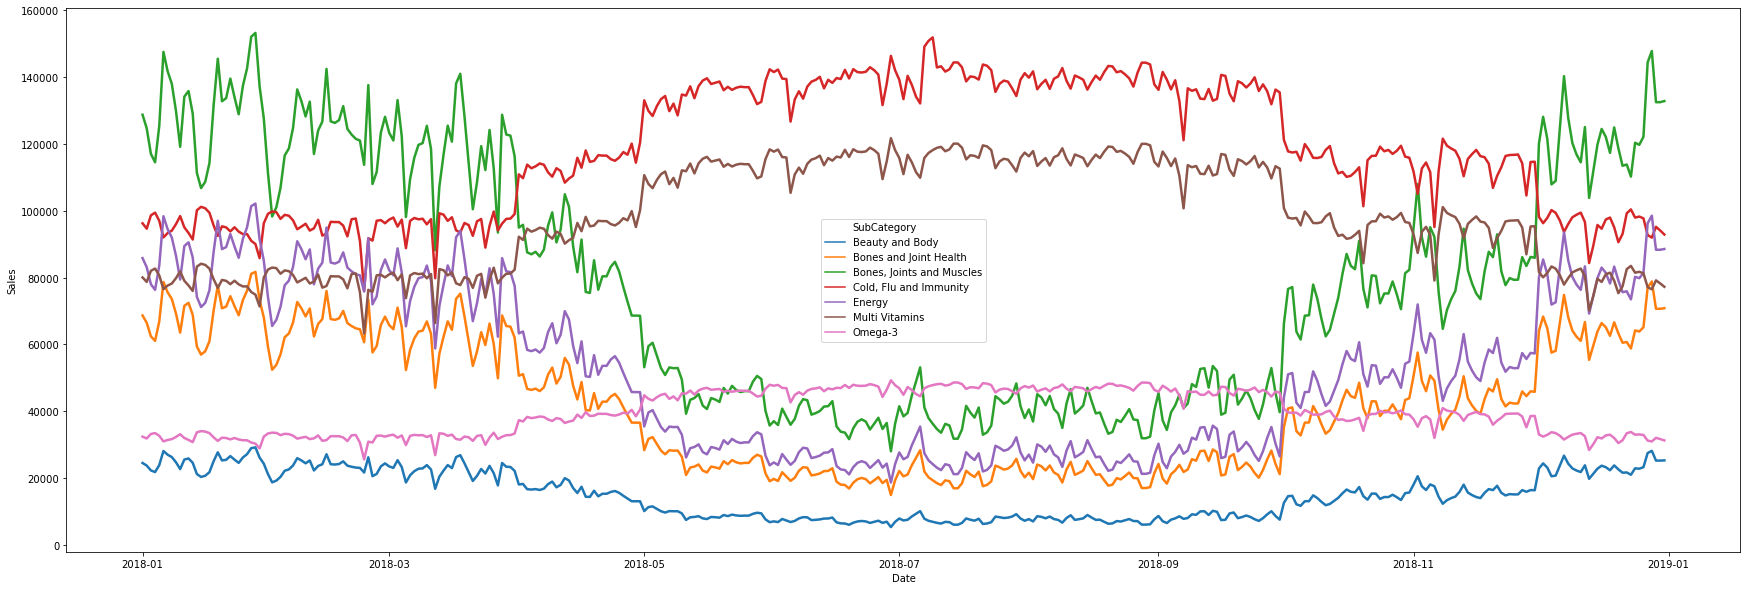

In [29]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(30,10))

# Plot the responses for different events and regions
ax = sns.lineplot(x=subcat['Time Date'], y=subcat['Value'],
             hue=subcat['SubCategory'], markers=True,
             data=subcat, palette="tab10", linewidth=2.5)
ax.set(xlabel='Date', ylabel='Sales')
#sns.lineplot(data=data, palette="tab10", linewidth=2.5)
#ax.set_xticklabels(labels=df_NationalAndStage['CrawlDate'],rotation=90)
plt.show()

### Plot Positive Weather Impact

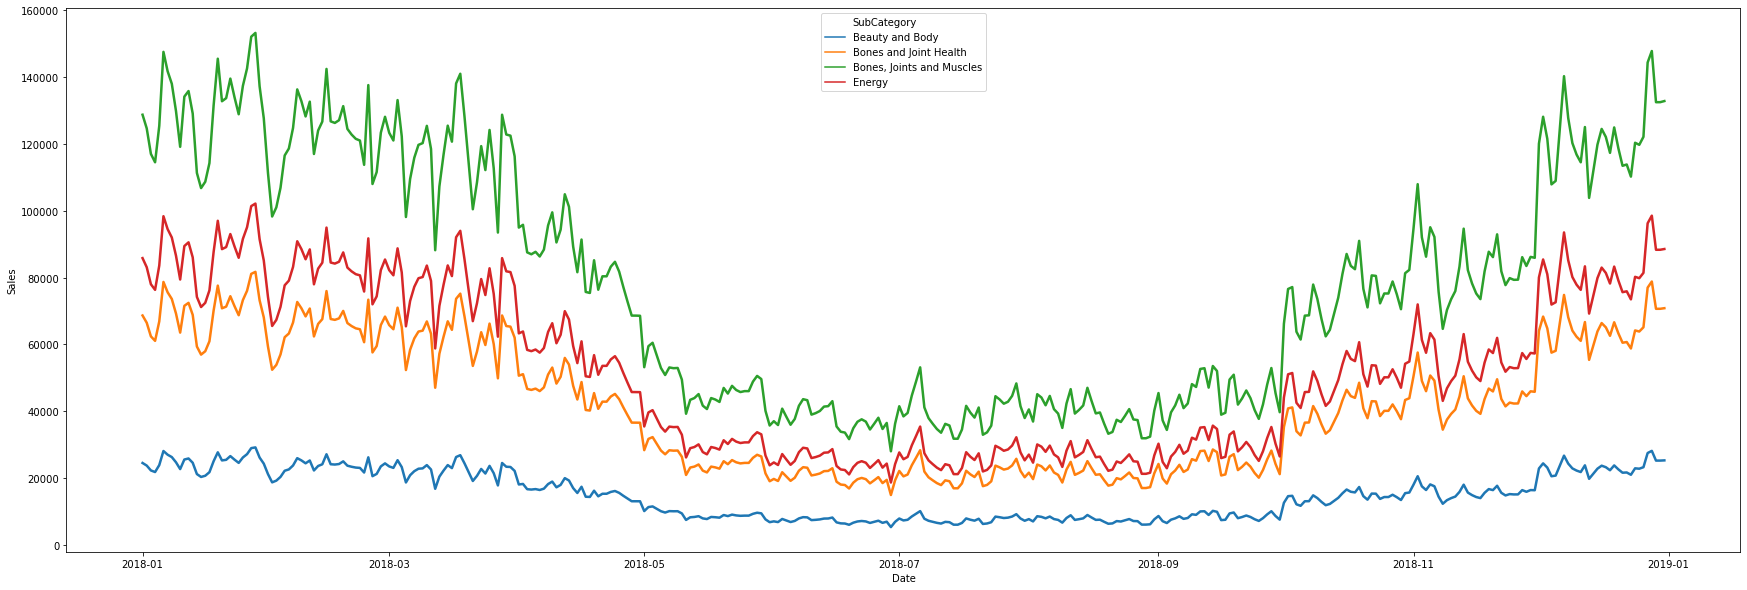

In [30]:
warnings.filterwarnings("ignore")
subcat = abt[abt['Good Weather Impact']=='Positive'].groupby(['SubCategory','Time Date']).sum()
subcat.reset_index(inplace=True)
plt.figure(figsize=(30,10))

# Plot the responses for different events and regions
ax = sns.lineplot(x=subcat['Time Date'], y=subcat['Value'],
             hue=subcat['SubCategory'], markers=True,
             data=subcat, palette="tab10", linewidth=2.5)
ax.set(xlabel='Date', ylabel='Sales')
#sns.lineplot(data=data, palette="tab10", linewidth=2.5)
#ax.set_xticklabels(labels=df_NationalAndStage['CrawlDate'],rotation=90)
plt.show()

### Plot Negative Sales

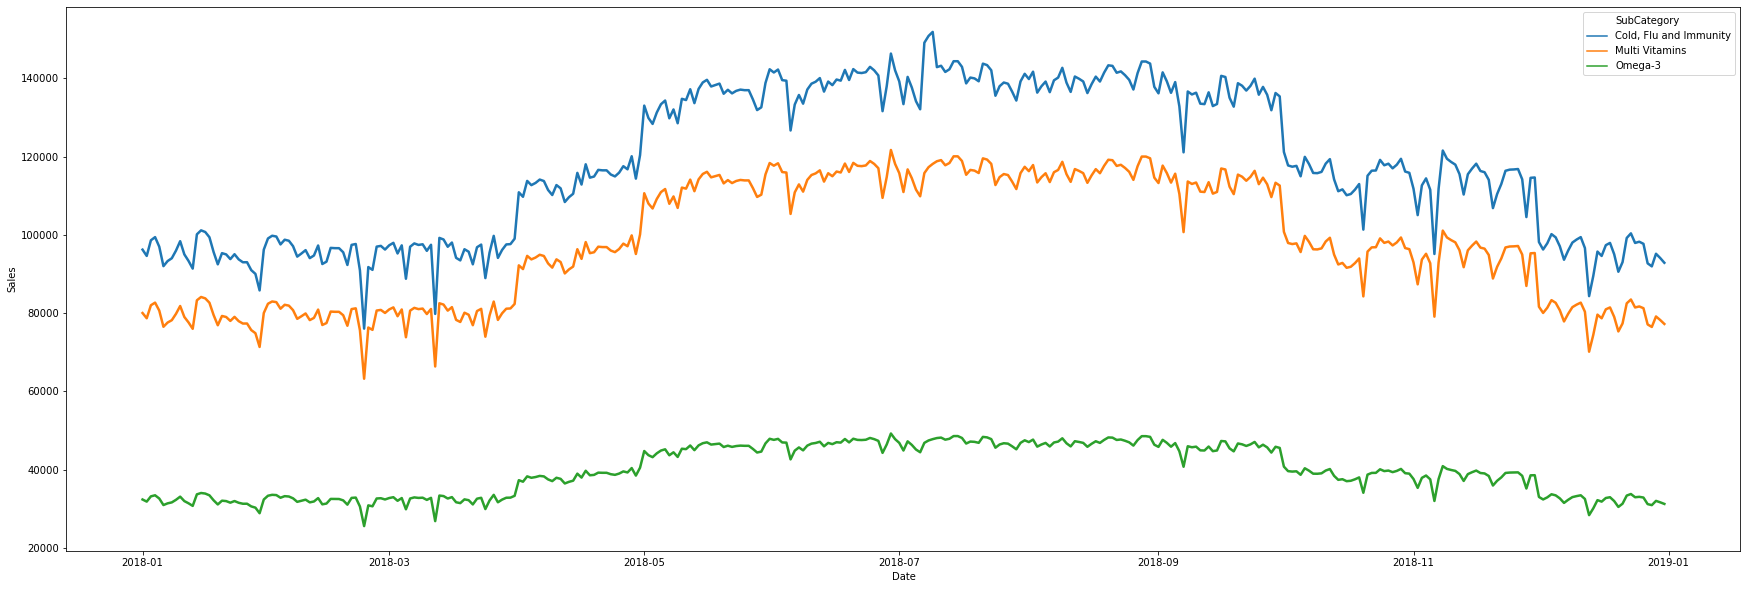

In [31]:
warnings.filterwarnings("ignore")
subcat = abt[abt['Good Weather Impact']=='Negative'].groupby(['SubCategory','Time Date']).sum()
subcat.reset_index(inplace=True)
plt.figure(figsize=(30,10))

# Plot the responses for different events and regions
ax = sns.lineplot(x=subcat['Time Date'], y=subcat['Value'],
             hue=subcat['SubCategory'], markers=True,
             data=subcat, palette="tab10", linewidth=2.5)
ax.set(xlabel='Date', ylabel='Sales')
#sns.lineplot(data=data, palette="tab10", linewidth=2.5)
#ax.set_xticklabels(labels=df_NationalAndStage['CrawlDate'],rotation=90)
plt.show()

## Analysing Correlation

### Overall Correlation
- Sales values appear to be strongly positively correlated with Brand Affinity,  Region Affluence. 
- There is also some weak positive correlation between sales and temperature.


In [32]:
abt.drop(['Lat','Long'],axis=1).corr()

,Value,RegionAffluence,Brand Affinity,Product Size,Temperature,Precipitation
Value,1.000000,3.350381e-01,6.917759e-01,-2.834156e-02,1.444193e-01,-5.246270e-02
RegionAffluence,0.335038,1.000000e+00,-2.322000e-15,-3.976169e-15,-1.852618e-02,-2.689019e-03
Brand Affinity,0.691776,-2.322000e-15,1.000000e+00,-1.627142e-03,-2.739217e-17,-2.723354e-15
Product Size,-0.028342,-3.976169e-15,-1.627142e-03,1.000000e+00,9.258097e-16,1.443949e-15
Temperature,0.144419,-1.852618e-02,-2.739217e-17,9.258097e-16,1.000000e+00,6.909131e-02
Precipitation,-0.052463,-2.689019e-03,-2.723354e-15,1.443949e-15,6.909131e-02,1.000000e+00


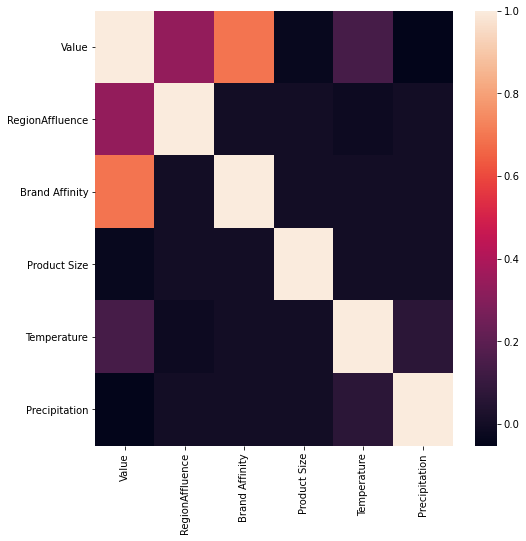

In [33]:
plt.figure(figsize=(8,8))
sns.heatmap(abt.drop(['Lat','Long'],axis=1).corr())
plt.show()

### Analysing Good Weather Impact Correlation - Positive Flags
- After filtering out sales for only those products with a Positive Good Weather Impact flat we can see there there is signifcantly stronger correlation with temperature. 
- This is consistent with the plots above where weather would be hotter during the summer months in Australia

In [34]:
abt[abt['Good Weather Impact']=='Positive'].drop(['Lat','Long'],axis=1).corr()

,Value,RegionAffluence,Brand Affinity,Product Size,Temperature,Precipitation
Value,1.000000,3.214016e-01,5.814742e-01,1.012682e-01,6.002420e-01,-2.252428e-02
RegionAffluence,0.321402,1.000000e+00,-1.896017e-18,3.628980e-18,-1.852618e-02,-2.689019e-03
Brand Affinity,0.581474,-1.896017e-18,1.000000e+00,1.741577e-01,-6.085947e-17,4.771153e-17
Product Size,0.101268,3.628980e-18,1.741577e-01,1.000000e+00,-2.829324e-17,1.739313e-17
Temperature,0.600242,-1.852618e-02,-6.085947e-17,-2.829324e-17,1.000000e+00,6.909131e-02
Precipitation,-0.022524,-2.689019e-03,4.771153e-17,1.739313e-17,6.909131e-02,1.000000e+00


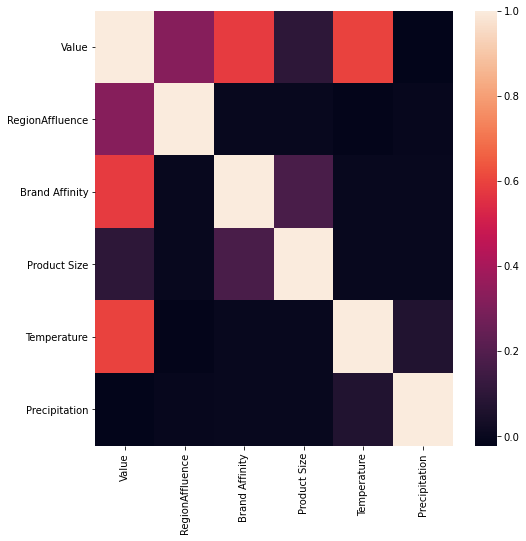

In [35]:
plt.figure(figsize=(8,8))
sns.heatmap(abt[abt['Good Weather Impact']=='Positive'].drop(['Lat','Long'],axis=1).corr())
plt.show()

### Analysing Good Weather Impact Correlation - Negative Flags
- After filtering out sales for only those products with a Negative Good Weather Impact flat we can see there there is stronger negative correlation with temperature.
- This is also consistent with the plots above where weather would be colder during the winter months in Australia

In [36]:
abt[abt['Good Weather Impact']=='Negative'].drop(['Lat','Long'],axis=1).corr()

,Value,RegionAffluence,Brand Affinity,Product Size,Temperature,Precipitation
Value,1.000000,3.673036e-01,8.557828e-01,-1.131751e-01,-2.256707e-01,-8.063901e-02
RegionAffluence,0.367304,1.000000e+00,5.550373e-16,-5.273895e-17,-1.852618e-02,-2.689019e-03
Brand Affinity,0.855783,5.550373e-16,1.000000e+00,-1.320906e-01,6.097422e-16,-3.958285e-15
Product Size,-0.113175,-5.273895e-17,-1.320906e-01,1.000000e+00,7.845841e-15,2.959192e-16
Temperature,-0.225671,-1.852618e-02,6.097422e-16,7.845841e-15,1.000000e+00,6.909131e-02
Precipitation,-0.080639,-2.689019e-03,-3.958285e-15,2.959192e-16,6.909131e-02,1.000000e+00


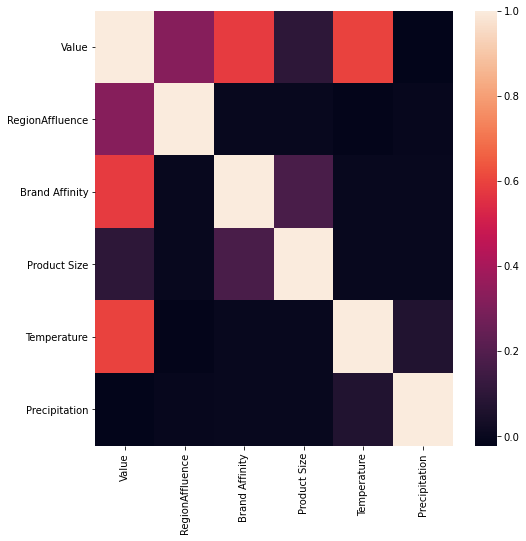

In [37]:
plt.figure(figsize=(8,8))
sns.heatmap(abt[abt['Good Weather Impact']=='Positive'].drop(['Lat','Long'],axis=1).corr())
plt.show()

# Data Preparation
<p>During the data understanding process there were a few key points which were uncovered. These were:</p>
<ul>
    <li>There are a number of features which are non-unique</li>
    <li>The Time Date column indicates that this data is time series based</li>
    <li>There are no missing values</li>
    <li>The account and product features need to be converted to categorical features</li>
</ul>

### Remove Unneeded Features

In [38]:
abt.describe(include='object')

,Product,Store,Store Description,Address,Suburb,State,Phone,ProductID,Good Weather Impact,Brand,Category,SubCategory,Description
count,453330,453330,453330,453330,453330,453330,453330,453330,453330,453330,453330,453330,453330
unique,69,18,18,18,18,3,18,69,2,16,1,7,69
top,2498307,QLD_CW_ST0098,Chemist Warehouse Indooroopilly,105 Haldon Street,Dandenong,NSW,02 9622 1939,2498307,Positive,Blackmores,Vitamins,"Cold, Flu and Immunity",Omega Double High Strength Fish Oil 90 Capsules
freq,6570,25185,25185,25185,25185,176295,25185,6570,229950,111690,453330,111690,6570


In [39]:
abt.drop(['Store Description', 'Address', 'Suburb', 'Phone', 'ProductID', 'Category', 'Description'], axis=1, inplace=True)

In [40]:
abt.head()

,Time Date,Product,Store,Value,State,Lat,Long,RegionAffluence,Good Weather Impact,Brand Affinity,Product Size,Brand,SubCategory,Temperature,Precipitation
0,2018-01-01,2511675,VIC_CW_ST0098,672.0,VIC,-37.81431,144.96374,1.2,Negative,10,60,Cenovis,"Cold, Flu and Immunity",20,0.0
1,2018-01-01,2511675,VIC_CW_ST0173,616.0,VIC,-37.81810,145.03587,1.1,Negative,10,60,Cenovis,"Cold, Flu and Immunity",20,0.0
2,2018-01-01,2511675,VIC_CW_ST0142,504.0,VIC,-37.76945,144.99879,0.9,Negative,10,60,Cenovis,"Cold, Flu and Immunity",20,0.0
3,2018-01-01,2511675,VIC_CW_ST0193,448.0,VIC,-37.73892,144.73822,0.8,Negative,10,60,Cenovis,"Cold, Flu and Immunity",20,0.0
4,2018-01-01,2511675,VIC_CW_ST0301,392.0,VIC,-37.98762,145.21420,0.7,Negative,10,60,Cenovis,"Cold, Flu and Immunity",20,0.0


In [41]:
abt.drop(['Lat', 'Long'], axis=1, inplace=True)

In [42]:
abt.head()

,Time Date,Product,Store,Value,State,RegionAffluence,Good Weather Impact,Brand Affinity,Product Size,Brand,SubCategory,Temperature,Precipitation
0,2018-01-01,2511675,VIC_CW_ST0098,672.0,VIC,1.2,Negative,10,60,Cenovis,"Cold, Flu and Immunity",20,0.0
1,2018-01-01,2511675,VIC_CW_ST0173,616.0,VIC,1.1,Negative,10,60,Cenovis,"Cold, Flu and Immunity",20,0.0
2,2018-01-01,2511675,VIC_CW_ST0142,504.0,VIC,0.9,Negative,10,60,Cenovis,"Cold, Flu and Immunity",20,0.0
3,2018-01-01,2511675,VIC_CW_ST0193,448.0,VIC,0.8,Negative,10,60,Cenovis,"Cold, Flu and Immunity",20,0.0
4,2018-01-01,2511675,VIC_CW_ST0301,392.0,VIC,0.7,Negative,10,60,Cenovis,"Cold, Flu and Immunity",20,0.0


## Remove features unlikely to add value

In [43]:
abt.drop(['State', 'Brand', 'SubCategory'], axis=1, inplace=True)

In [44]:
abt.head()

,Time Date,Product,Store,Value,RegionAffluence,Good Weather Impact,Brand Affinity,Product Size,Temperature,Precipitation
0,2018-01-01,2511675,VIC_CW_ST0098,672.0,1.2,Negative,10,60,20,0.0
1,2018-01-01,2511675,VIC_CW_ST0173,616.0,1.1,Negative,10,60,20,0.0
2,2018-01-01,2511675,VIC_CW_ST0142,504.0,0.9,Negative,10,60,20,0.0
3,2018-01-01,2511675,VIC_CW_ST0193,448.0,0.8,Negative,10,60,20,0.0
4,2018-01-01,2511675,VIC_CW_ST0301,392.0,0.7,Negative,10,60,20,0.0


### Increase Richness of Timescale

This datepart function is adopted from the fastai library developed by Jeremy Howard and team. 

In [45]:
import re
import numpy as np

def ifnone(a,b):
    "`a` if `a` is not None, otherwise `b`."
    return b if a is None else a

def make_date(df, date_field:str):
    "Make sure `df[field_name]` is of the right date type."
    field_dtype = df[date_field].dtype
    if isinstance(field_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        field_dtype = np.datetime64
    if not np.issubdtype(field_dtype, np.datetime64):
        df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)
        
def add_datepart(df, field_name:str, prefix:str=None, drop:bool=True, time:bool=False):
    "Helper function that adds columns relevant to a date in the column `field_name` of `df`."
    "Sourced from FastAI"
    make_date(df, field_name)
    field = df[field_name]
    prefix = ifnone(prefix, re.sub('[Dd]ate$', '', field_name))
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[prefix + n] = getattr(field.dt, n.lower())
    df[prefix + 'Elapsed'] = field.astype(np.int64) // 10 ** 9
    if drop: df.drop(field_name, axis=1, inplace=True)
    return df

In [46]:
abt = add_datepart(abt, 'Time Date')

In [47]:
abt.head()

,Product,Store,Value,RegionAffluence,Good Weather Impact,Brand Affinity,Product Size,Temperature,Precipitation,Time Year,...,Time Day,Time Dayofweek,Time Dayofyear,Time Is_month_end,Time Is_month_start,Time Is_quarter_end,Time Is_quarter_start,Time Is_year_end,Time Is_year_start,Time Elapsed
0,2511675,VIC_CW_ST0098,672.0,1.2,Negative,10,60,20,0.0,2018,...,1,0,1,False,True,False,True,False,True,1514764800
1,2511675,VIC_CW_ST0173,616.0,1.1,Negative,10,60,20,0.0,2018,...,1,0,1,False,True,False,True,False,True,1514764800
2,2511675,VIC_CW_ST0142,504.0,0.9,Negative,10,60,20,0.0,2018,...,1,0,1,False,True,False,True,False,True,1514764800
3,2511675,VIC_CW_ST0193,448.0,0.8,Negative,10,60,20,0.0,2018,...,1,0,1,False,True,False,True,False,True,1514764800
4,2511675,VIC_CW_ST0301,392.0,0.7,Negative,10,60,20,0.0,2018,...,1,0,1,False,True,False,True,False,True,1514764800


### Simplifying the Data Pipeline

In [48]:
def get_abt():
    abt = pd.merge(df, stores, how='left')
    abt = pd.merge(abt, products, left_on='Product', right_on='ProductID', how='left')
    abt = pd.merge(abt, weather, left_on=['State', 'Time Date'], right_on=['State','Date'], how='left')
    abt.drop('Date',axis = 1, inplace=True)
    abt['Time Date'] = abt['Time Date'].apply(lambda x: '0' + str(x) if len(str(x)) < 8 else str(x))
    abt['Time Date'] = pd.to_datetime(abt['Time Date'], format='%d%m%Y')
    abt.drop(['Lat','Long'],axis=1).corr()
    abt.drop(['Store Description', 'Address', 'Suburb', 'Phone', 'ProductID', 'Category', 'Description'], axis=1, inplace=True)
    abt.drop(['State', 'Brand', 'SubCategory'], axis=1, inplace=True)
    abt.drop(['Lat', 'Long'], axis=1, inplace=True) 
    abt = add_datepart(abt, 'Time Date', drop=False)
    abt.sort_values(by=['Time Date', 'Product', 'Store'])
    return abt

In [49]:
abt = get_abt()

In [50]:
abt.head()

,Time Date,Product,Store,Value,RegionAffluence,Good Weather Impact,Brand Affinity,Product Size,Temperature,Precipitation,...,Time Day,Time Dayofweek,Time Dayofyear,Time Is_month_end,Time Is_month_start,Time Is_quarter_end,Time Is_quarter_start,Time Is_year_end,Time Is_year_start,Time Elapsed
0,2018-01-01,2511675,VIC_CW_ST0098,672.0,1.2,Negative,10,60,20,0.0,...,1,0,1,False,True,False,True,False,True,1514764800
1,2018-01-01,2511675,VIC_CW_ST0173,616.0,1.1,Negative,10,60,20,0.0,...,1,0,1,False,True,False,True,False,True,1514764800
2,2018-01-01,2511675,VIC_CW_ST0142,504.0,0.9,Negative,10,60,20,0.0,...,1,0,1,False,True,False,True,False,True,1514764800
3,2018-01-01,2511675,VIC_CW_ST0193,448.0,0.8,Negative,10,60,20,0.0,...,1,0,1,False,True,False,True,False,True,1514764800
4,2018-01-01,2511675,VIC_CW_ST0301,392.0,0.7,Negative,10,60,20,0.0,...,1,0,1,False,True,False,True,False,True,1514764800


# Modelling

In [51]:
modabt = pd.get_dummies(abt.drop(['Time Date', 'Product', 'Store'], axis=1))

In [52]:
y = modabt['Value']
X = modabt.drop('Value', axis=1)

### Split Data into Train and Test

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
np.random.seed(42)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=42)

In [56]:
X_train.head(2)

,RegionAffluence,Brand Affinity,Product Size,Temperature,Precipitation,Time Year,Time Month,Time Week,Time Day,Time Dayofweek,Time Dayofyear,Time Is_month_end,Time Is_month_start,Time Is_quarter_end,Time Is_quarter_start,Time Is_year_end,Time Is_year_start,Time Elapsed,Good Weather Impact_Negative,Good Weather Impact_Positive
19531,1.1,10,40,7,0.00,2018,7,28,11,2,192,False,False,False,False,False,False,1531267200,1,0
405780,0.7,7,30,21,0.25,2018,10,42,16,1,289,False,False,False,False,False,False,1539648000,0,1


In [57]:
X_test.head(2)

,RegionAffluence,Brand Affinity,Product Size,Temperature,Precipitation,Time Year,Time Month,Time Week,Time Day,Time Dayofweek,Time Dayofyear,Time Is_month_end,Time Is_month_start,Time Is_quarter_end,Time Is_quarter_start,Time Is_year_end,Time Is_year_start,Time Elapsed,Good Weather Impact_Negative,Good Weather Impact_Positive
27520,0.7,2,168,16,0.0,2018,9,39,27,3,270,False,False,False,False,False,False,1538006400,1,0
349571,1.2,10,200,16,0.0,2018,7,29,18,2,199,False,False,False,False,False,False,1531872000,0,1


In [58]:
y_train.head(2)

19531     920.70000
405780    239.49975
Name: Value, dtype: float64

In [59]:
y_test.head(2)

27520     105.84
349571    320.00
Name: Value, dtype: float64

### Import Models

In [60]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

### Import Processing and Model Selection Tools

In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [62]:
random_state = 42

In [63]:
# GB and NN algorithms take a significant amount of time to train
# Uncomment the lines if you want these to train
pipelines = {
    #'ridge': make_pipeline(StandardScaler(), Ridge(random_state)),
    #'lasso': make_pipeline(StandardScaler(), Lasso(random_state)),
    #'enet': make_pipeline(StandardScaler(), ElasticNet(random_state)),
    'rf': make_pipeline(StandardScaler(), RandomForestRegressor(random_state)),
    #'gb': make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state)),
    #'nn': make_pipeline(StandardScaler(), MLPRegressor(random_state))
}

In [64]:
hyper ={
    'ridge': {'ridge__alpha':[0.01, 0.1, 0.5, 1.0]},
    'lasso': {'lasso__alpha':[0.01, 0.1, 0.5, 1.0]},
    'enet': {'elasticnet__alpha':[0.01, 0.1, 0.5, 1.0]},
    'rf': {'randomforestregressor__min_samples_split':[2,4,6]},
    'gb': {'gradientboostingregressor__alpha':[0.001, 0.005, 0.01]},
    'nn': {'mlpregressor__max_iter':[100,200], 'mlpregressor__solver':['adam', 'sgd'], 'mlpregressor__learning_rate':['invscaling', 'constant','adaptive']},
}

In [65]:
from sklearn.pipeline import Pipeline

In [66]:
X_train.shape

(45333, 20)

In [67]:
fit_models = {}
for algo, pipeline in pipelines.items():
    print(algo)
    model = GridSearchCV(pipeline, hyper[algo], n_jobs=-1, cv=10)
    model.fit(X_train, y_train)
    fit_models[algo] = model.fit(X_train, y_train)
    print('Fit '+ algo)

rf
Fit rf


In [68]:
# Export models after training to save progress
import pickle
with open('fitmodels_generated.pkl', 'wb') as f:
    pickle.dump(fit_models, f)

In [69]:
model = fit_models['rf']

# Model Evaluation
Training against the RF algorithm yielded the following results:
- Test MSE: 97.19
- R2: .9985
- MAE: 3.308

### Analyse Results

In [70]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [71]:
for algo, model in fit_models.items():
    y_hat = model.predict(X_test)
    mse = mean_squared_error(y_test, y_hat)
    mae = mean_absolute_error(y_test, y_hat)
    r2 = r2_score(y_test, y_hat)
    print('{}: Test MSE is {}, Test R2 is {}, Test MAE is {}'.format(algo, mse, r2, mae))

rf: Test MSE is 116.1919290092102, Test R2 is 0.9982593962136996, Test MAE is 3.4588678351814686


### Visualize Results

In [72]:
model = fit_models['rf'].best_estimator_

In [73]:
y_hat = model.predict(X)

In [74]:
abt['yhat'] = y_hat
abt['y_test'] = y

In [75]:
vizdata = abt[['Time Date', 'yhat', 'y_test']].groupby('Time Date').sum()

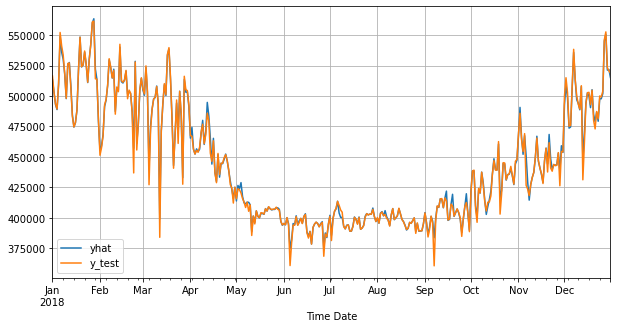

In [76]:
vizdata.reset_index().plot(x='Time Date', y=['yhat', 'y_test'], figsize=(10,5), grid=True)
plt.show()

In [77]:
abt['Diff'] = abt['yhat'] - abt['y_test']

In [78]:
vizdata = abt[['Time Date', 'Store', 'Diff']].groupby(['Time Date', 'Store']).sum().reset_index()

### Visualise Errors

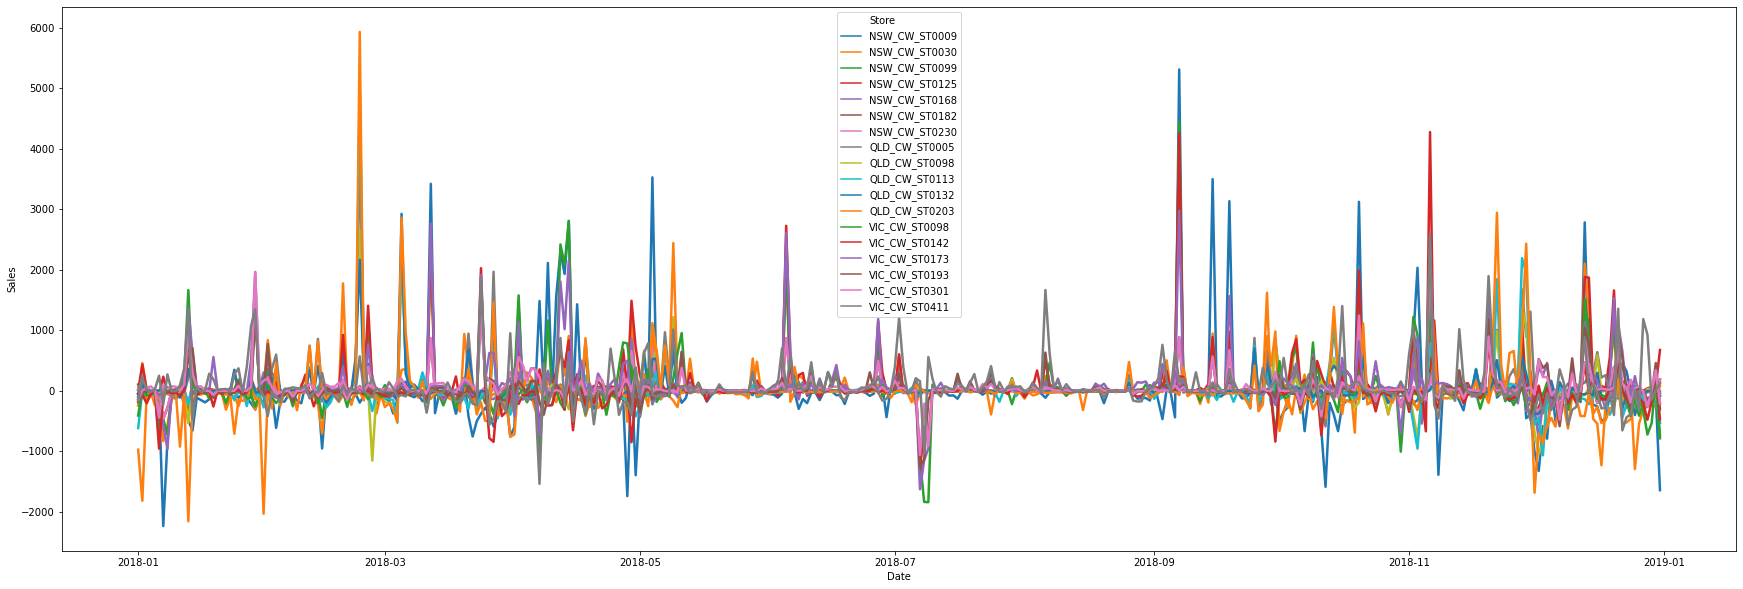

In [79]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(30,10))

# Plot the responses for different events and regions
ax = sns.lineplot(x=vizdata['Time Date'], y=vizdata['Diff'],
             hue=vizdata['Store'], markers=True,
             data=vizdata, palette="tab10", linewidth=2.5)
ax.set(xlabel='Date', ylabel='Sales')
plt.show()

### Aalyse Feature Importance
Product was the most important feature.

In [80]:
featureimp = fit_models['rf'].best_estimator_.named_steps['randomforestregressor'].feature_importances_
#featureimp = fit_models['rf'].best_estimator_.named_steps['rf'].coef_

In [81]:
imp = {}
for num, key in enumerate(X.columns[:19]):
    imp[key] = featureimp[num]

In [82]:
pd.DataFrame(pd.Series(imp)).sort_values(by=0, ascending=False)

,0
Brand Affinity,5.003529e-01
Temperature,2.005381e-01
RegionAffluence,1.414778e-01
Good Weather Impact_Negative,3.666534e-02
Time Elapsed,1.006423e-02
Time Dayofyear,9.686533e-03
Time Month,9.001787e-03
Time Week,8.645790e-03
Precipitation,5.438909e-03
Product Size,2.220211e-03


# Deployment

### Deploy to WML
DEPLOYMENT PRE WORK STEP 1: First, get the appropriate URL based on your Watson Machine Learning Service Location: https://cloud.ibm.com/apidocs/machine-learning#endpoint-url
- Dallas: https://us-south.ml.cloud.ibm.com
- London - https://eu-gb.ml.cloud.ibm.com
- Frankfurt - https://eu-de.ml.cloud.ibm.com
- Tokyo - https://jp-tok.ml.cloud.ibm.com

DEPLOYMENT PRE WORK STEP 2: Then a deployment space: https://youtu.be/tUHl5TiP_oA?t=446

DEPLOYMENT PRE WORK STEP 3: And grab your Cloud API Key: https://youtu.be/tUHl5TiP_oA?t=647

In [85]:
# Install ibm_watson_machine_learning if not installed already
!pip install -U ibm_watson_machine_learning

Requirement already up-to-date: ibm-watson-machine-learning in /opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages (1.0.45)


## Import Dependencies

In [86]:
from ibm_watson_machine_learning import APIClient
import json
import numpy as np

## Authenticate and Set Deployment Space

In [87]:
wml_credentials = {
    "apikey":"<IBM CLOUD API KEY>", #From DEPLOYMENT PRE WORK STEP 3
    "url":"<WATSON MACHINE LEARNING URL>" # From DEPLOYMENT PRE WORK STEP 1
}

In [ ]:
wml_client = APIClient(wml_credentials)
wml_client.spaces.list()

In [89]:
# Select a space ID from one of the deployment spaces shown above
SPACE_ID="<WATSON MACHINE LEARNING DEPLOYMENT SPACE ID>" #From DEPLOYMENT PRE WORK STEP 2

In [90]:
wml_client.set.default_space(SPACE_ID)

'SUCCESS'

# Save and Deploy The Model

In [91]:
MODEL_NAME = 'Sales Regression Model'
DEPLOYMENT_NAME = 'Sales Regression Model'
BEST_MODEL = model

In [93]:
# Set Python Version
software_spec_uid = wml_client.software_specifications.get_id_by_name('default_py3.7')

# Setup model meta
model_props = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME, 
    wml_client.repository.ModelMetaNames.TYPE: 'scikit-learn_0.23', 
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid 
}

#Save model
model_details = wml_client.repository.store_model(
    model=BEST_MODEL, 
    meta_props=model_props, 
    training_data=X_train.head(), 
    training_target=y_train.head()
)

In [94]:
model_details

{'entity': {'label_column': 'Value',
  'software_spec': {'id': 'e4429883-c883-42b6-87a8-f419d64088cd',
   'name': 'default_py3.7'},
  'training_data_references': [{'connection': {'access_key_id': 'not_applicable',
     'endpoint_url': 'not_applicable',
     'secret_access_key': 'not_applicable'},
    'id': '1',
    'location': {},
    'schema': {'fields': [{'name': 'RegionAffluence', 'type': 'float64'},
      {'name': 'Brand Affinity', 'type': 'int64'},
      {'name': 'Product Size', 'type': 'int64'},
      {'name': 'Temperature', 'type': 'int64'},
      {'name': 'Precipitation', 'type': 'float64'},
      {'name': 'Time Year', 'type': 'int64'},
      {'name': 'Time Month', 'type': 'int64'},
      {'name': 'Time Week', 'type': 'int64'},
      {'name': 'Time Day', 'type': 'int64'},
      {'name': 'Time Dayofweek', 'type': 'int64'},
      {'name': 'Time Dayofyear', 'type': 'int64'},
      {'name': 'Time Is_month_end', 'type': 'bool'},
      {'name': 'Time Is_month_start', 'type': 'bool'},

In [ ]:
model_uid = wml_client.repository.get_model_uid(model_details); model_uid

In [ ]:
# Set meta
deployment_props = {
    wml_client.deployments.ConfigurationMetaNames.NAME:DEPLOYMENT_NAME, 
    wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
}

# Deploy
deployment = wml_client.deployments.create(
    artifact_uid=model_uid, 
    meta_props=deployment_props 
)

# Output result
deployment

### Test out the Deployment

In [97]:
deployment_uid = wml_client.deployments.get_uid(deployment) # TAKE NOTE OF THIS ID, YOU'LL NEED IT FOR YOUR TM1 INTEGRATION
payload = {"input_data":
           [
               {"fields":X_test.columns.to_numpy().tolist(), "values":X_test.to_numpy().tolist()}
           ]
          }
result = wml_client.deployments.score(deployment_uid, payload); result

{'predictions': [{'fields': ['prediction'],
   'values': [[105.53333333333342],
    [320.0],
    [532.0],
    [932.77638],
    [966.0],
    [118.21708111023806],
    [507.77479619047614],
    [142.928838],
    [140.0],
    [631.3761385714288],
    [158.55714285714276],
    [56.551179999999995],
    [53.031730499999995],
    [634.2299999999997],
    [535.3733000000001],
    [102.98646941190472],
    [277.66666670000023],
    [109.93441219047617],
    [726.0],
    [181.47216571428567],
    [594.0],
    [235.1319457142857],
    [287.210441902381],
    [818.95125],
    [142.57577142857147],
    [821.7000000000004],
    [626.4000000000005],
    [234.0],
    [279.63923555476174],
    [187.92000000000004],
    [36.87701233333333],
    [453.46500000000003],
    [52.075946825476194],
    [458.0283000000001],
    [115.23874999999998],
    [903.73331],
    [231.1872844428571],
    [491.4000000000001],
    [145.78701589761909],
    [473.99237485714303],
    [35.691854333333325],
    [796.223520000